# *Discerning Haggis* 2016-ml-contest submission

**Author:** [Carlos Alberto da Costa Filho](http://www.researchgate.net/profile/Carlos_Da_Costa_Filho), University of Edinburgh

![UoE](https://www.eusa.ed.ac.uk/asset/Organisation/16256/School%20Pages%20GeoSciences.jpg?thumbnail_width=1140&thumbnail_height=150&resize_type=ResizeFitAll)


## Load libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(style='whitegrid',
        rc={'lines.linewidth': 2.5,
            'figure.figsize': (10, 8),
            'text.usetex': False,
            # 'font.family': 'sans-serif',
            # 'font.sans-serif': 'Optima LT Std',
        })

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import truncnorm

## Convenience functions

In [2]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc


adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))


## Load, treat and color data
We try smoothing the data using several windows.

In [158]:
perf = []
windows = []

In [176]:
windows_new = list(range(15, 30, 1))
for window in windows_new:
    validationFull = pd.read_csv('../validation_data_nofacies.csv')
    training_data = pd.read_csv('../facies_vectors.csv')

    # Treat Data
    training_data.fillna(training_data.mean(),inplace=True)
    for col in ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']:
        training_data[col] = training_data[col].rolling(window=window).sum()
    training_data.fillna(method='backfill',inplace=True)
    training_data['Well Name'] = training_data['Well Name'].astype('category')
    training_data['Formation'] = training_data['Formation'].astype('category')
    training_data['Well Name'].unique()
    training_data.describe()

    # Color Data
    # 1=sandstone  2=c_siltstone   3=f_siltstone 
    # 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
    # 8=packstone 9=bafflestone
    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
           '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

    facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                     'WS', 'D','PS', 'BS']
    #facies_color_map is a dictionary that maps facies labels
    #to their respective colors
    facies_color_map = {}
    for ind, label in enumerate(facies_labels):
        facies_color_map[label] = facies_colors[ind]

    def label_facies(row, labels):
        return labels[ row['Facies'] -1]

    training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
    #make_facies_log_plot(
    #    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    #    facies_colors)

    correct_facies_labels = training_data['Facies'].values

    feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
    feature_vectors.describe()

    scaler = preprocessing.StandardScaler().fit(feature_vectors)
    scaled_features = scaler.transform(feature_vectors)

    X_train, X_test, y_train, y_test = train_test_split(scaled_features,
            correct_facies_labels, test_size=0.2)

    clf = MLPClassifier(solver='lbfgs', alpha=.1,
                        hidden_layer_sizes=(300,300,300))
    clf.fit(X_train,y_train)
    conf_te = confusion_matrix(y_test, clf.predict(X_test))
    perf.append(100*accuracy(conf_te))
    print('Predicted accuracy: %.3f%%' % (100*accuracy(conf_te),))
print('Done')
windows += windows_new

Predicted accuracy: 79.157%
Predicted accuracy: 80.000%
Predicted accuracy: 80.723%
Predicted accuracy: 81.446%
Predicted accuracy: 79.157%
Predicted accuracy: 76.747%
Predicted accuracy: 79.880%
Predicted accuracy: 80.000%
Predicted accuracy: 82.771%
Predicted accuracy: 81.446%
Predicted accuracy: 78.916%
Predicted accuracy: 80.964%
Predicted accuracy: 79.759%
Predicted accuracy: 78.193%
Predicted accuracy: 80.000%
Done


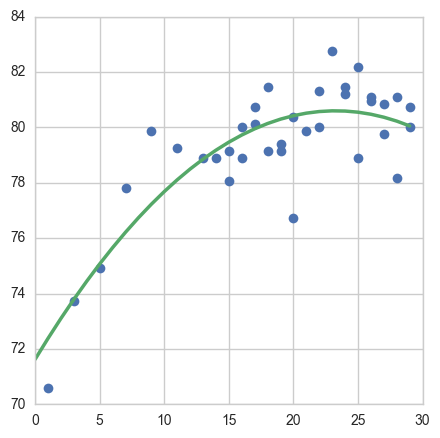

In [181]:
p = np.poly1d(np.polyfit(windows, perf, 2))
f, ax = plt.subplots(figsize=(5,5))
ax.plot(windows, perf, 'o')
ax.plot(range(max(windows)+1), p(range(max(windows)+1)))

In [183]:
validationFull = pd.read_csv('../validation_data_nofacies.csv')
training_data = pd.read_csv('../facies_vectors.csv')

# Treat Data
training_data.fillna(training_data.mean(),inplace=True)
for col in ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']:
    training_data[col] = training_data[col].rolling(window=25).sum()
training_data.fillna(method='backfill',inplace=True)
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()
training_data.describe()

# Color Data
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
#make_facies_log_plot(
#    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
#    facies_colors)

correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

X_train, X_test, y_train, y_test = train_test_split(scaled_features,
        correct_facies_labels, test_size=0.2)

clf = MLPClassifier(solver='lbfgs', alpha=.1,
                    hidden_layer_sizes=(300,300,300))
clf.fit(X_train,y_train)
conf_te = confusion_matrix(y_test, clf.predict(X_test))

print('Predicted accuracy: %.3f%%' % (100*accuracy(conf_te),))

Predicted accuracy: 79.880%


## Retrain and predict
Finally we train a neural network using *all* data available, and apply it to our blind test.

In [188]:
clf_final = MLPClassifier(solver='lbfgs', alpha=0.1,
                        hidden_layer_sizes=(300,300,300))
clf_final.fit(scaled_features,correct_facies_labels)

validationFullsm = validationFull.copy()
for col in ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']:
    validationFullsm[col] = validationFullsm[col].rolling(window=25).sum()
validationFullsm.fillna(method='backfill',inplace=True)

validation_features = validationFullsm.drop(['Formation', 'Well Name', 'Depth'], axis=1)
scaled_validation = scaler.transform(validation_features)
validation_output = clf_final.predict(scaled_validation)
validationFull['Facies']=validation_output
#validationFull.to_csv('well_data_with_facies_DH.csv')

ValueError: operands could not be broadcast together with shapes (830,8) (7,) (830,8) 